# 0. 라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
# 더 많은 특성을 보기 위한 설정
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

# 1. 파일 입력

In [3]:
data_path = '/Users/minguinho/Downloads/데이콘/코인 예측/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv") # 임의의 시점 부터 2021년 1월 31일까지 9가지 종류의 암호화폐의 분단위 가격정보를 가공한 데이터
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv") # 임의의 시점 부터 2021년 1월 31일까지 9가지 종류의 암호화폐의 분단위 가격정보를 가공한 데이터
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv") # 2021년 2월 1일 부터 임의의 시점까지 9가지 종류의 암호화폐의 분단위 가격정보를 가공한 데이터

In [8]:
# 데이터 확인
train_x_df.shape

(10159560, 12)

In [9]:
train_y_df.shape

(883440, 12)

In [10]:
test_x_df.shape

(730020, 12)

sample_id : 개별 샘플의 인덱스
<br>
time : x_df는 0분 ~ 1379분, y_df는 0분 ~ 119분의 값을 갖습니다. 동일한 샘플 내 시간 정보
<br>
coin_index : 10가지 종류의 코인에 대한 비식별화 인덱스 (0 ~9)
<br>
open : open price
<br>
high : high price
<br>
low : low price
<br>
close : close price
<br>
volume : 거래량
<br>
quote_av : quote asset volume
<br>
trades : 거래 건 수
<br>
tb_base_av : taker buy base asset volume
<br>
tb_quote_av : taker buy quote asset volume
<br>
<br>
라고 한다.

In [11]:
# coin_index로 코인별 데이터를 확인해보자.
print(train_x_df['coin_index'].value_counts())
print()
print(train_y_df['coin_index'].value_counts())
print()
print(test_x_df['coin_index'].value_counts())

8    1625640
9    1625640
6    1469700
7    1306860
4    1283400
0    1251660
5     752100
1     527160
3     178020
2     139380
Name: coin_index, dtype: int64

8    141360
9    141360
6    127800
7    113640
4    111600
0    108840
5     65400
1     45840
3     15480
2     12120
Name: coin_index, dtype: int64

0    73140
1    73140
2    73140
3    73140
4    73140
5    73140
6    73140
7    73140
8    73140
9    71760
Name: coin_index, dtype: int64


In [18]:
# coin_index로 코인별 데이터를 확인해보자.
print(train_x_df['sample_id'].value_counts())
print()
print(train_y_df['sample_id'].value_counts())
print()
print(test_x_df['sample_id'].value_counts())

0       1380
4919    1380
4913    1380
4912    1380
4915    1380
        ... 
2451    1380
2448    1380
2449    1380
2446    1380
7360    1380
Name: sample_id, Length: 7362, dtype: int64

0       120
849     120
4435    120
6482    120
337     120
       ... 
4769    120
6816    120
163     120
2210    120
2047    120
Name: sample_id, Length: 7362, dtype: int64

0      1380
331    1380
345    1380
344    1380
343    1380
       ... 
154    1380
153    1380
152    1380
151    1380
511    1380
Name: sample_id, Length: 529, dtype: int64


In [20]:
print(train_x_df['sample_id'].max()) # 0~7361
print()
print(train_y_df['sample_id'].max())
print()
print(test_x_df['sample_id'].max()) # 0~528
# 각 샘플은 모두 (23, 2)시간의 코인 데이터를 갖고 있다. 

7361

7361

528


In [13]:
train_x_df 
# 7362가지의 sample이 있다. 각 샘플마다 23시간(train_x)와 2시간(train_y)동안 코인을 기록한 데이터가 있다. 
# 각 코인이 가지고 있는 sample 개수는 균등하지 않다.

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
10159555,7361,1375,8,1.000668,1.001669,1.000626,1.001502,9.180907e+00,2203.059082,2.245034,6.229020e+00,1494.727417
10159556,7361,1376,8,1.001627,1.001920,1.000960,1.001294,7.963097e+00,1911.151611,2.211651,3.056139e+00,733.490601
10159557,7361,1377,8,1.001294,1.001461,1.000584,1.000668,3.849893e+00,923.610718,1.260224,2.284546e+00,548.042297
10159558,7361,1378,8,1.000709,1.000751,1.000042,1.000042,1.337402e+00,320.624756,0.826239,5.164965e-01,123.819839


In [16]:
train_x_df[train_x_df['coin_index'] == 0].groupby(['sample_id'], as_index=False).count() 
# 0번 코인 데이터를 groupby로 봤다. 
#1, 16, 19...7355, 7360번 샘플이 0번 코인의 데이터들이다. 

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,1,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
1,16,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
2,19,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
3,26,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
4,30,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
...,...,...,...,...,...,...,...,...,...,...,...,...
902,7336,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
903,7343,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
904,7347,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
905,7355,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380


In [15]:
train_x_df[(train_x_df['coin_index'] == 0) & (train_x_df['sample_id'] == 1)] 
# 0번 코인 데이터 중 sample_id가 1인 데이터들을 보자
# sample_id == 1일 때 [0~1379분] 동안 0번 코인의 데이터. 즉, 23시간동안 코인의 정보를 분 단위로 기록한거다. 
# 23시간동안 눈 한번도 깜빡 안하고 쭈우욱 지켜본다고 생각하면 된다. 

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
1380,1,0,0,1.106169,1.106169,1.104910,1.104910,13.367957,46.954517,1.573812,2.732137,9.601550
1381,1,1,0,1.104879,1.104879,1.104312,1.104312,272.751038,957.261902,2.203336,0.000000,0.000000
1382,1,2,0,1.104407,1.105319,1.103683,1.103683,105.794769,371.359741,6.295247,73.229462,257.038788
1383,1,3,0,1.103683,1.104470,1.102518,1.102675,535.659424,1877.284180,8.813346,13.796035,48.367622
1384,1,4,0,1.102675,1.102675,1.101448,1.102140,1145.788452,4012.176758,15.423355,78.489143,274.863922
...,...,...,...,...,...,...,...,...,...,...,...,...
2755,1,1375,0,0.997734,0.997734,0.997576,0.997702,30.613787,97.036522,1.259049,1.986150,6.294707
2756,1,1376,0,0.997356,0.998646,0.997136,0.998646,62.543278,198.280609,3.147624,29.512119,93.613388
2757,1,1377,0,0.998583,0.998583,0.998269,0.998269,4.749764,15.066854,1.259049,3.175952,10.075510
2758,1,1378,0,0.998552,1.000094,0.997734,1.000094,2804.963867,8900.436523,10.387157,2044.243042,6485.336914


In [12]:
train_y_df[(train_y_df['coin_index'] == 0) & (train_y_df['sample_id'] == 1)] 
# time = 0일 때 '무조건'코인을 매수해야함. 최저점 찾아서 매수한다 이런거 없다.
# time = 0일 때 나의 재산 중 이 코인에 투자할 비율(0~1)을 결정 하고 0~119의 time 중 어느 시점에 매도할지 결정하는 모델을 만들어야한다. 
# 즉, submission 파일은 sample_id, buy_quantity(구매량, %기 때문에 다 합하면 1이 된다.), sell_time(구매한 코인을 팔 time)
# 대회가 어떻게 돌아가는지 보자
# train_x가 입력값이라 가정하자. 우선 sample_id == 1인 것부터 시작한다. sample_id = 1인 코인의 23시간 그래프(train_x)를 입력받으면 향후 2시간동안의 예측 그래프(train_y)가 나온다. 
# 이 train_y를 입력값으로 받는 함수를 만든다. 이 함수는 각 sample_id의 최대값이 나오는(==나올거라 예측하는) time을 반환한다. 이 역시 pandas로 저장하던가 뭐 어디에 저장한다. 즉, 각 샘플당 최고점 위치를 받는거다. 
# 샘플 개수가 400개면 (400, 2)꼴의 데이터가 저장되는 것. (sample, 최고점 time)
# 저장한 데이터를 입력값으로 받는 함수를 만든다. 이 함수는 각 sample_id의 y값의 time = 0 때 얼마나 투자해야 최고점에서 판매할 때 가장 많은 돈이 남는지 계산하게 된다. 즉, buy_quantity를 출력값으로 하고 최고점이 나오는 시간대를 입력값으로 받는 함수를 만드는 것
# 이렇게 submission 파일이 만들려고 하는데...이게 맞는지 나중에 확인해봐야한다. 

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
120,1,0,0,1.000504,1.000535,1.000504,1.000535,5.177841,16.458494,0.944287,5.177841,16.458494
121,1,1,0,0.999654,0.999654,0.999591,0.999591,74.331123,236.054169,2.832861,0.000000,0.000000
122,1,2,0,0.999559,0.999559,0.998332,0.999182,1432.489746,4546.403809,7.869059,704.135986,2234.468994
123,1,3,0,1.000441,1.000441,0.999780,0.999874,5.760151,18.300951,1.573812,5.760151,18.300951
124,1,4,0,0.999622,0.999622,0.998206,0.999119,64.249290,203.860489,4.721435,5.574441,17.698793
...,...,...,...,...,...,...,...,...,...,...,...,...
235,1,115,0,1.021152,1.022033,1.021152,1.022033,306.786255,995.998901,3.777148,146.474655,475.597656
236,1,116,0,1.021183,1.021215,1.021183,1.021183,194.120224,629.790649,1.259049,192.184448,623.510376
237,1,117,0,1.022191,1.022191,1.020932,1.021089,177.393768,575.503296,4.091910,126.931068,411.799072
238,1,118,0,1.020774,1.021372,1.020522,1.021372,32.203335,104.437065,3.777148,8.800755,28.548702


In [13]:
test_x_df[(test_x_df['coin_index'] == 0) & (test_x_df['sample_id'] == 1)] # 23시간짜리 거래량
# train으로 학습시키고 이 23시간 동안의 데이터를 본 다음 향후 2시간동안 코인 시세를 예측, 최적의 구매량, 최적의 매도 시점을 예측해 최고의 수익을 올리는 모델을 만드는 것이 목표다. 

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
1380,1,0,0,1.005289,1.005996,1.005214,1.005698,8013.482422,21637.847656,51.769089,5856.718750,15814.302734
1381,1,1,0,1.005698,1.005698,1.005661,1.005698,4094.793213,11057.156250,21.973930,3947.590576,10659.678711
1382,1,2,0,1.005698,1.006816,1.005698,1.005847,3588.279541,9694.051758,28.305401,1179.713257,3186.028809
1383,1,3,0,1.005773,1.005773,1.004246,1.004320,3964.167725,10694.910156,24.208567,1286.946045,3471.489502
1384,1,4,0,1.004358,1.005140,1.004209,1.004991,3016.588623,8138.322754,32.402237,2466.845459,6655.474609
...,...,...,...,...,...,...,...,...,...,...,...,...
2755,1,1375,0,0.999628,1.000447,0.999628,1.000224,2194.100586,5891.282227,18.994413,1194.502808,3207.499023
2756,1,1376,0,1.000075,1.000075,0.999292,0.999888,3052.201172,8190.883301,11.918063,1245.817505,3342.692383
2757,1,1377,0,1.000037,1.000633,0.999925,1.000335,1028.625732,2762.194336,17.877096,527.895752,1417.622925
2758,1,1378,0,1.000149,1.000373,1.000000,1.000000,565.526978,1518.596924,4.841713,186.219742,500.092255


정리해보자
<br>
train 데이터셋 : 7362개의 sample, 각 샘플마다 23시간 분량의 코인 정보(time = 0~1379, x), 2시간 분량의 코인 정보(0~119, y)
<br>
test 데이터셋 : 529개의 sample, 각 샘플마다 23시간 분량의 코인 정보(0~1379, x)

# 2. 데이터 가공, 확인
### 데이터를 3차원 numpy array로 가공해보자. (코인 샘플, 각 샘플당 시간(x면 23시간, y면 2시간), 각 시간당 특성(10개)) 양식이다.

In [7]:
def df2d_to_array3d(df_2d): # 2차원으로 나열된걸 3차원으로 변경해보자. 데이콘 ppt에 소개된 데이터 구조대로 바꿔주는 것
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [8]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [9]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''') # 샘플 개수, 각 샘플별 시간, 특성


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
test_x_array (529, 1380, 10)



## 데이터를 그래프로 확인해보기

In [10]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series') # 23시간짜리 x 그래프
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series') # 2시간짜리 y 그래프
    plt.axhline(1, c = 'red')
    plt.legend()

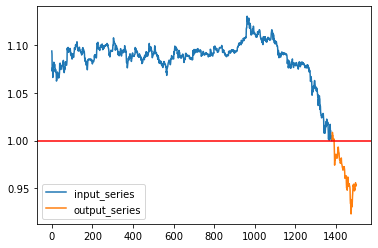

In [55]:
# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 1012
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()
# 구매량을 결정한 이유를 알았다. 
# 그래프 보면 고점 찍고 확 떨어지는게 눈에 보이는 코인인데 y 데이터에서 time = 0일 때 일단 사긴 사야되니까 최소량만큼 사고 최소한의 손해를 볼 수 있는 선에서 팔 수 있게 하는거다. 이 때는 sell_quantity = 0으로 할 수 있겠다. 

# 3. 모델 생성, 훈련
### 데이콘에서 데이터를 학습할 수 있게 다 가공해놨다. 친절한 데이콘
### 그래서 바로 모델을 만들고 훈련시킬 수 있다. 

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [69]:
WINDOW_SIZE=30
BATCH_SIZE=120

all_data = np.concatenate((train_x_array[idx,:,1], train_y_array[idx,:,1]), axis=0)
all_data_for_pred = windowed_dataset(all_data, WINDOW_SIZE, BATCH_SIZE, False)
train_data = windowed_dataset(train_x_array[idx,:,1], WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(train_y_array[idx,:,1], WINDOW_SIZE, BATCH_SIZE, False)

In [70]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (120, 30, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (120, 1)


In [71]:
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[WINDOW_SIZE, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True, activation='tanh'),
  tf.keras.layers.LSTM(64, activation='tanh'),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [73]:
optimizer = tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [74]:
history = model.fit(train_data, validation_data=(test_data), epochs=50, callbacks=[checkpoint])

Epoch 1/50
12/12 [==============================] - 5s 123ms/step - loss: 0.5750 - mae: 1.0750 - val_loss: 0.3990 - val_mae: 0.8931

Epoch 00001: val_loss improved from inf to 0.39896, saving model to tmp/ckeckpointer.ckpt
Epoch 2/50
12/12 [==============================] - 1s 44ms/step - loss: 0.4909 - mae: 0.9902 - val_loss: 0.2853 - val_mae: 0.7552

Epoch 00002: val_loss improved from 0.39896 to 0.28526, saving model to tmp/ckeckpointer.ckpt
Epoch 3/50
12/12 [==============================] - 1s 43ms/step - loss: 0.3555 - mae: 0.8422 - val_loss: 0.1831 - val_mae: 0.6050

Epoch 00003: val_loss improved from 0.28526 to 0.18311, saving model to tmp/ckeckpointer.ckpt
Epoch 4/50
12/12 [==============================] - 1s 44ms/step - loss: 0.2390 - mae: 0.6902 - val_loss: 0.1073 - val_mae: 0.4630

Epoch 00004: val_loss improved from 0.18311 to 0.10731, saving model to tmp/ckeckpointer.ckpt
Epoch 5/50
12/12 [==============================] - 1s 43ms/step - loss: 0.1511 - mae: 0.5484 - val

In [75]:
model.load_weights(filename)

In [79]:
pred = model.predict(train_data)

In [80]:
pred.shape # 31분~1380분 예측 

(1350, 1)

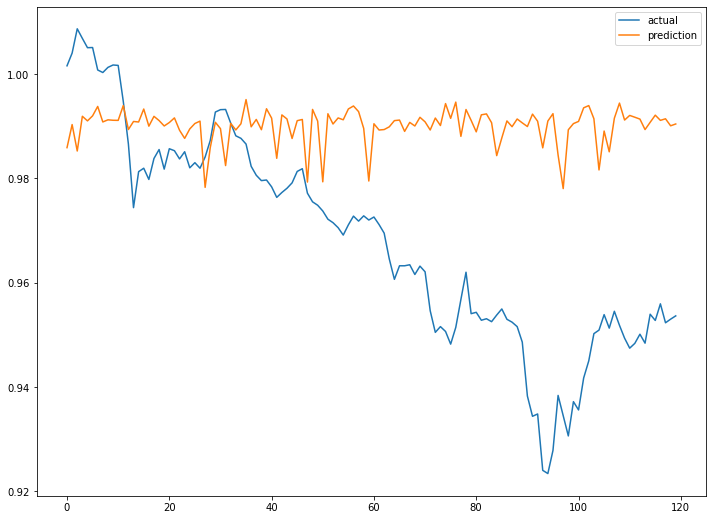

In [81]:
plt.figure(figsize=(12, 9))
plt.plot(train_y_array[idx,:,1], label='actual') # 도대체 뭘 학습한거냐?
plt.plot(pred[-120:], label='prediction')
plt.legend()
plt.show()